In [82]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from hyperopt import STATUS_OK, hp, fmin, tpe, Trials
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read parquet file as dataframe
df = pd.read_parquet('bert_transformed.parquet')
df['reduced_category'] = df['reduced_category'].replace('News', 'General')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   category          209056 non-null  object
 1   text              209056 non-null  object
 2   reduced_category  209056 non-null  object
 3   embeddings        209056 non-null  object
dtypes: object(4)
memory usage: 8.0+ MB


In [3]:
# Faltten embeddings to prepare for modeling
embedding_cols = [f"embeddings_{i}" for i in range(768)] 

# Convert the embeddings to Dataframe
embedding_df = pd.DataFrame(df['embeddings'].tolist(), index=df.index, columns=embedding_cols)

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, embedding_df], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Columns: 772 entries, category to embeddings_767
dtypes: float32(768), object(4)
memory usage: 620.4+ MB


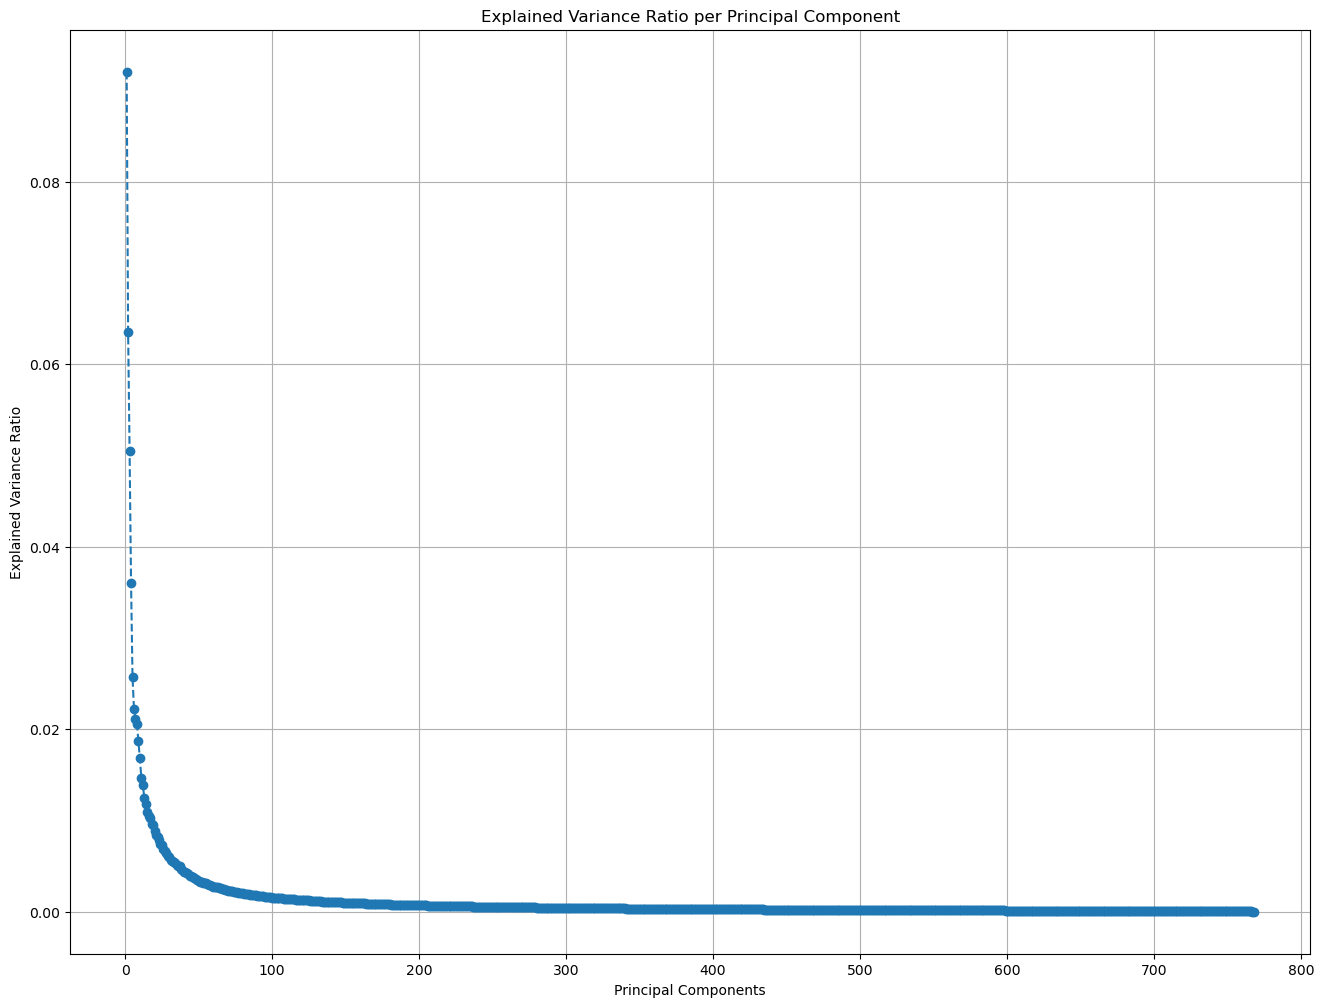

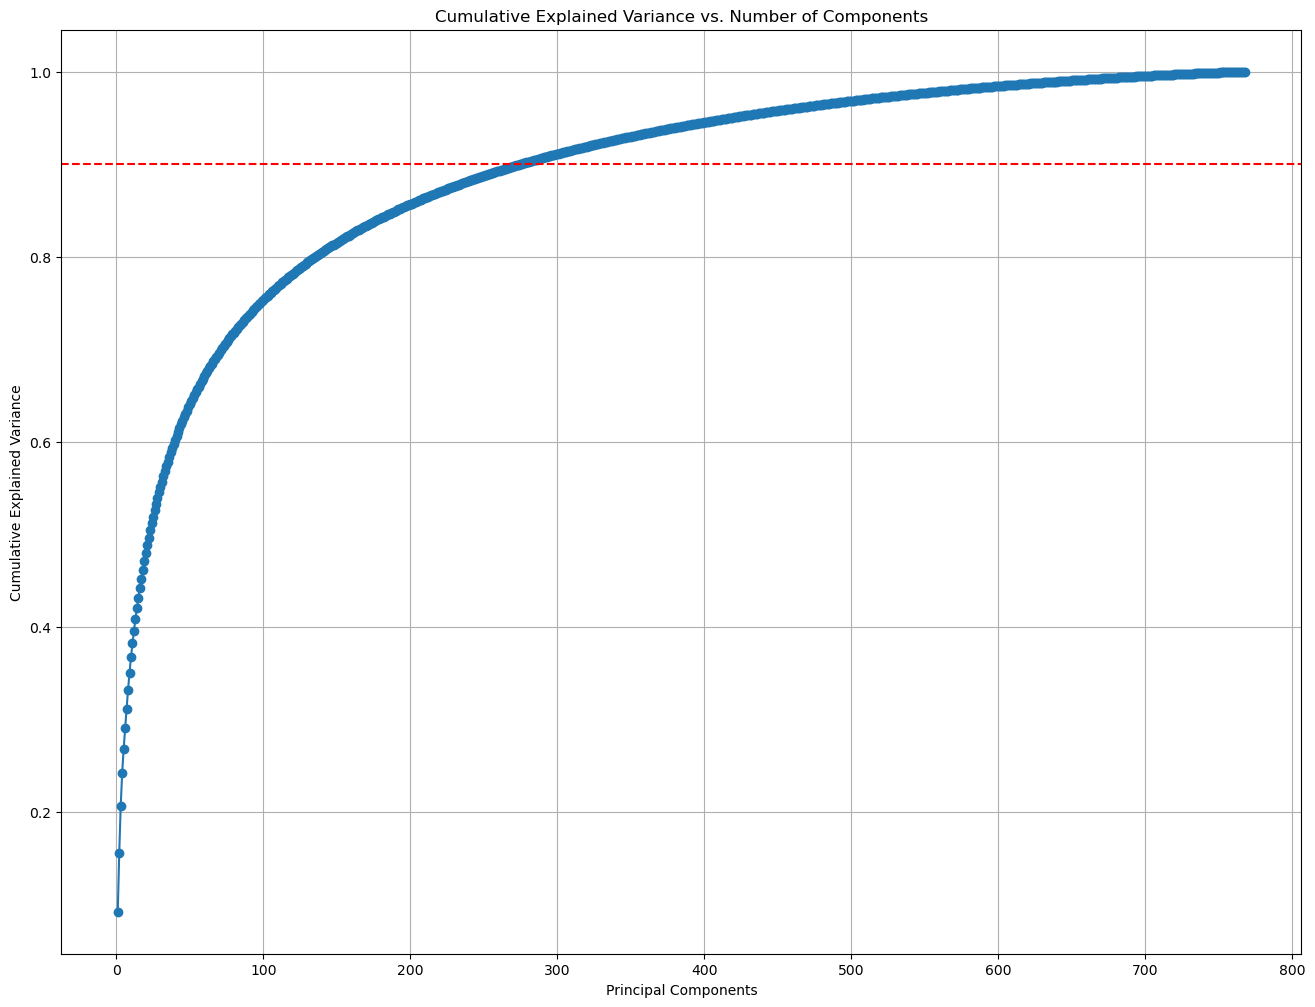

Number of components to retain 90.0% variance: 275


In [4]:
# Perform dimension reduction with PCA

# Initialize global variables
threshold = 0.9

# Transform embeddings into numpy array
embeddings_matrix = embedding_df.values

# Fit PCA and calculate explained variance ratio for different components
pca = PCA()
pca.fit(embeddings_matrix)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio (Elbow method)
plt.figure(figsize=(16, 12))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Step 5: Plot cumulative explained variance to identify the optimal number of components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(16, 12))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.axhline(y=threshold, color='r', linestyle='--')  # Threshold for 95% variance
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Identify the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components to retain {threshold * 100}% variance: {optimal_components}")

# Apply PCA to reduce to the optimal number of components
pca = PCA(n_components=optimal_components)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

# Create a dataframe with the reduced embeddings
reduced_embedding_cols = [f"pca_component_{i+1}" for i in range(optimal_components)]
reduced_embedding_df = pd.DataFrame(reduced_embeddings, columns=reduced_embedding_cols, index=embedding_df.index)

# Concatenate the reduced embeddings back to the original dataframe and drop the original embedding columns
df = pd.concat([df, reduced_embedding_df], axis=1)
df = df.drop(columns=embedding_cols)
df = df.drop(columns=['embeddings'])

In [5]:
# Initialize test and training dataset split
X = df.drop(columns=['category', 'reduced_category', 'text'])  # Drop the target column (labels)
y = df['reduced_category']  # The target column

In [6]:
# Initialize number of folds and dictionary to store metrics
k = 5

results = {
    'Model': [],
    'Accuracy': [],
    'Accuracy SD': [],
    'Precision': [],
    'Precision SD': [],
    'Recall': [],
    'Recall SD': [],
    'F1-Score': [],
    'F1-Score SD': [],
}

In [7]:
# Define metric computing functions
def compute_metrics(y_test, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    return metrics

def append_metrics(result, model_name, accuracies, precisions, recalls, f1s):
    results['Model'].append(model_name)
    results['Accuracy'].append(np.mean(accuracies))
    results['Accuracy SD'].append(np.std(accuracies))
    results['Precision'].append(np.mean(precisions))
    results['Precision SD'].append(np.std(precisions))
    results['Recall'].append(np.mean(recalls))
    results['Recall SD'].append(np.std(recalls))
    results['F1-Score'].append(np.mean(f1s))
    results['F1-Score SD'].append(np.std(f1s))

def plot_confusion_matrix(avg_cm, model_name, k):
    plt.figure(figsize=(12, 10))
    sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f"Average Confusion Matrix for {model_name} ({k}-fold CV)")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

# Scaler function for certain models that are sensitive to scale
scaler = StandardScaler()

In [83]:
# Logistic Regression hyperparameter search with GridSearch

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter grid for C (regulization strength)
param_grid = {'C': [0.001, 0.01, 0.05]}

# Initialize the Logistic Regression model 
log_reg = LogisticRegression(
    penalty='l2',
    solver='sag',
    max_iter=200,
    random_state=24  
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation folds
    scoring='accuracy', 
    verbose=3,
    n_jobs=-1
 )

grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found by Grid Search
print(f"Optimal hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/jonathanwang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathanwang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathanwang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathanwang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathanwang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathanwang/anaconda3/

[CV 1/5] END ............................C=0.01;, score=0.740 total time=  47.1s
Optimal hyperparameters: {'C': 0.05}


/Users/jonathanwang/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ............................C=0.01;, score=0.741 total time= 1.0min


[CV 4/5] END ............................C=0.01;, score=0.738 total time= 2.7min
[CV 5/5] END ............................C=0.01;, score=0.737 total time= 2.7min
[CV 3/5] END ............................C=0.01;, score=0.743 total time= 2.7min
[CV 5/5] END ...........................C=0.001;, score=0.736 total time=  14.5s
[CV 1/5] END ............................C=0.05;, score=0.739 total time= 2.6min
[CV 4/5] END ...........................C=0.001;, score=0.737 total time=  15.0s
[CV 2/5] END ............................C=0.05;, score=0.741 total time= 2.6min
[CV 3/5] END ...........................C=0.001;, score=0.740 total time=  15.4s
[CV 5/5] END ............................C=0.05;, score=0.738 total time= 2.6min
[CV 1/5] END ...........................C=0.001;, score=0.738 total time=  15.2s
[CV 3/5] END ............................C=0.05;, score=0.742 total time= 2.6min
[CV 2/5] END ...........................C=0.001;, score=0.739 total time=  15.3s
[CV 4/5] END ...............

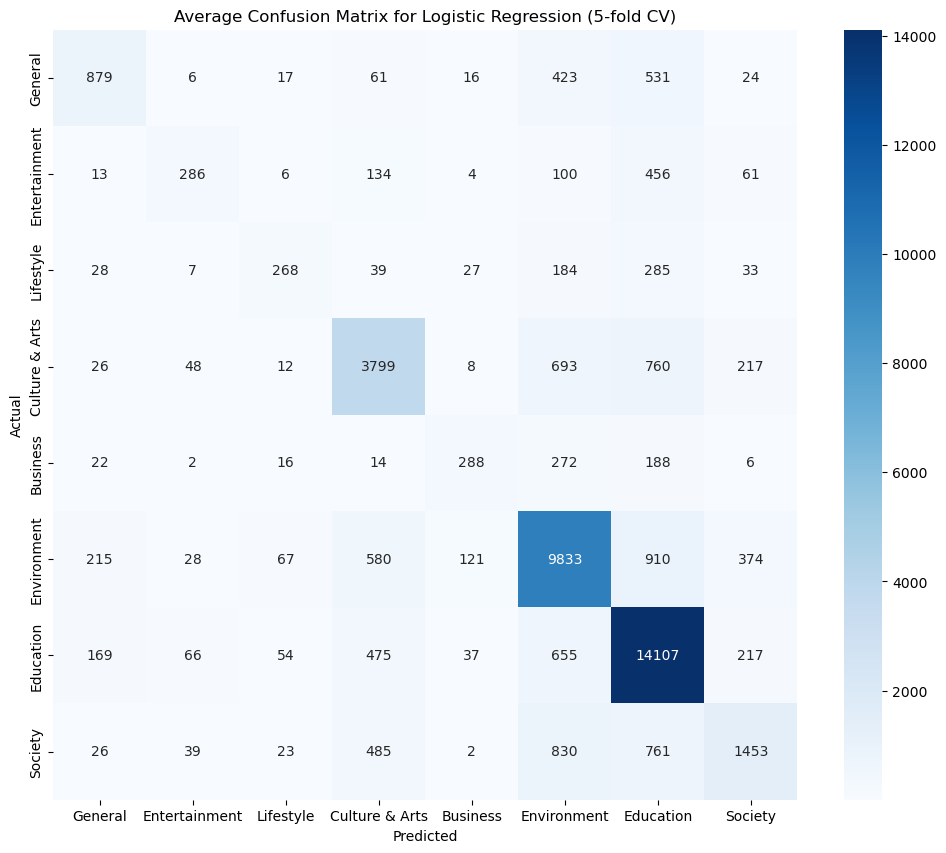

In [85]:
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=32)
model = LogisticRegression(solver='lbfgs', penalty="l2", C=grid_search.best_params_['C'])
model_name = "Logistic Regression"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []


# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the scaler on the training and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = compute_metrics(y_test, y_pred)['accuracy']
    precision = compute_metrics(y_test, y_pred)['precision']
    recall = compute_metrics(y_test, y_pred)['recall']
    f1 = compute_metrics(y_test, y_pred)['f1']

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap (average confusion matrix)
plot_confusion_matrix(avg_cm, model_name, k)

In [11]:
# Linear SVC hyperparameter search with GridSearch

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'C': [0.1, 1, 10, 100]}

# Initialize the LinearSVC model
svc_model = LinearSVC(max_iter=1000, random_state=24, class_weight='balanced')

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=svc_model, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5,  
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found by Grid Search
print(f"Optimal C: {grid_search.best_params_['C']}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END .............................C=0.1;, score=0.731 total time=  31.3s
[CV 4/5] END ..............................C=10;, score=0.733 total time=  29.4s
[CV 4/5] END ...............................C=1;, score=0.733 total time=  31.2s
[CV 3/5] END ..............................C=10;, score=0.737 total time=  29.6s
[CV 4/5] END .............................C=0.1;, score=0.733 total time=  31.5s
[CV 2/5] END .............................C=100;, score=0.734 total time=  29.6s
[CV 2/5] END ...............................C=1;, score=0.734 total time=  31.4s
[CV 5/5] END ..............................C=10;, score=0.731 total time=  29.8s
[CV 3/5] END .............................C=0.1;, score=0.737 total time=  31.6s
[CV 4/5] END .............................C=100;, score=0.733 total time=  29.6s
[CV 5/5] END ...............................C=1;, score=0.731 total time=  31.4s
[CV 1/5] END .............................C=100;,

Average Accuracy across 5-folds: 0.7067


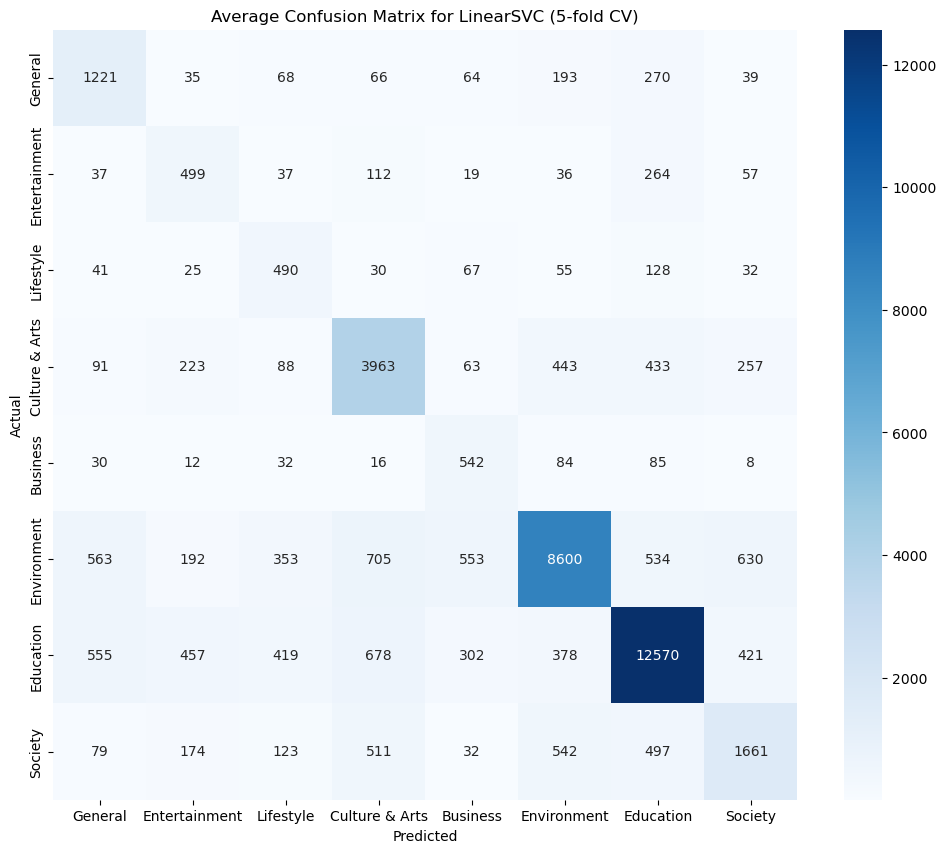

In [15]:
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=32)
model = LinearSVC(C=grid_search.best_params_['C'], random_state=24, class_weight='balanced') 
model_name = "LinearSVC"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the scaler on the training and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = compute_metrics(y_test, y_pred)['accuracy']
    precision = compute_metrics(y_test, y_pred)['precision']
    recall = compute_metrics(y_test, y_pred)['recall']
    f1 = compute_metrics(y_test, y_pred)['f1']

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap (average confusion matrix)
plot_confusion_matrix(avg_cm, model_name, k)

1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
Average Accuracy across 5-folds: 0.7399


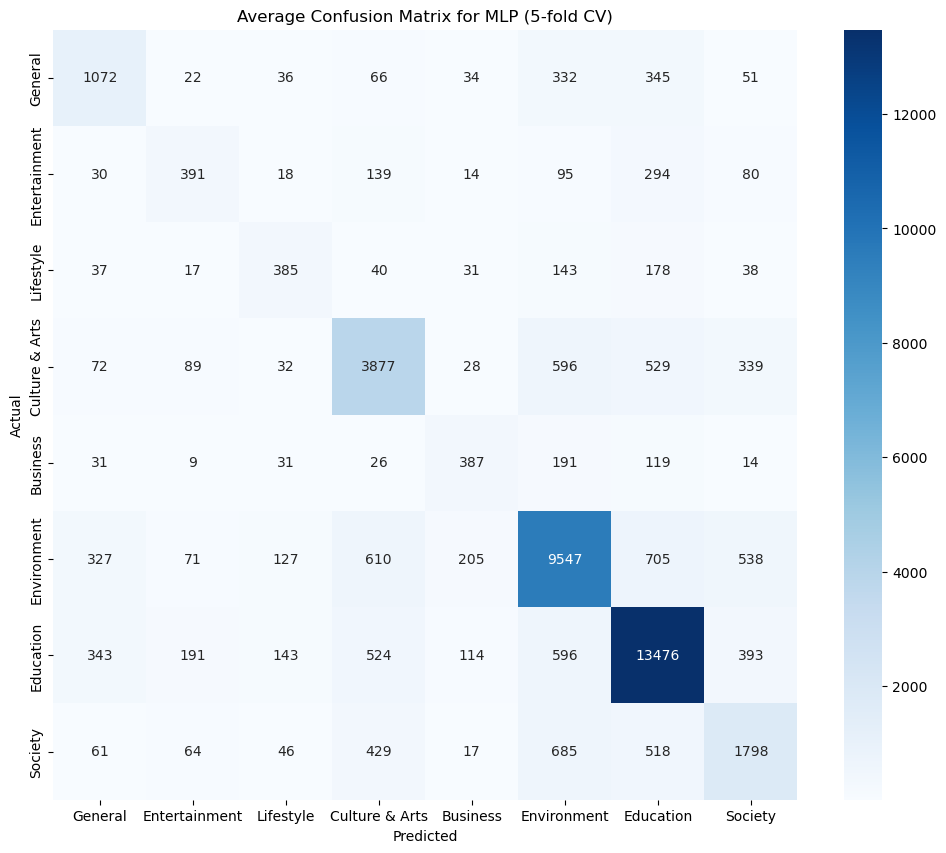

In [78]:
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=32)

# Initialize model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')  # Assuming 8 classes for multi-class classification
])
model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model_name = "MLP"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []

# Encode y for MLP
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # 6. Train the model
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

    # 7. Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

    # 8. Calculate metrics for this fold
    metrics = compute_metrics(y_test, y_pred_classes)
    
    accuracies.append(metrics['accuracy'])
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1s.append(metrics['f1'])

    # 9. Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred_classes)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap (average confusion matrix)
plot_confusion_matrix(avg_cm, model_name, k)

In [19]:
# Model comparison results
results_df = pd.DataFrame(results)
print("Overall Model Performance Comparison over " + str(k) + " folds")
results_df

Overall Model Performance Comparison over 5 folds


,Model,Accuracy,Accuracy SD,Precision,Precision SD,Recall,Recall SD,F1-Score,F1-Score SD
0,LDA,0.720788,0.001873,0.7188,0.002459,0.720788,0.001873,0.717971,0.002121
1,LDA,0.720788,0.001873,0.7188,0.002459,0.720788,0.001873,0.717971,0.002121
